**Default rifting with sediment**

In [1]:
import UWGeodynamics as GEO
import glucifer

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

**Scaling**

In [3]:
half_rate = 1.8 * u.centimeter / u.year
model_length = 360e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

**finite strain for rifting events**

In [4]:
finite_strain = 0.
length = 360.0 * u.kilometer # km
rift_length = length * (1+finite_strain)
print(rift_length)

360.0 kilometer


**Define model variables**

In [5]:
#resolution
#res = (64,32)
res = (128, 64)

rift_velocity = 5.0 * u.centimeters / u.year
rift_time = rift_length/rift_velocity

print(rift_velocity.to_base_units())
print(rift_time.to(u.megayear))

model_name = "outputs_riftDef_5cmyr_r1"

1.58443823204e-09 meter / second
7.2 megayear


**Define the external geometry**

In [6]:
Model = GEO.Model(elementRes=res, 
                  minCoord=(0. * u.kilometer, -110. * u.kilometer), 
                  maxCoord=(360. * u.kilometer, 10. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [7]:
Model.outputDir = model_name

In [ ]:
with mesh.deform_mesh():
    mesh.data[:,0] = mesh.data[:,0] * np.exp(mesh.data[:,0]*mesh.data[:,0]/4) / np.exp(maxCoord[0]*maxCoord[0]/4)
    mesh.data[:,1] = mesh.data[:,1] * np.exp(mesh.data[:,1]*mesh.data[:,1]*4) / np.exp(maxCoord[1]*maxCoord[1]*4)


In [ ]:
Fig = glucifer.Figure(figsize=(1200,400), title="Mesh", quality=3)
Fig.Mesh(Model.mesh)
Fig.show()

**Add Materials**

In [8]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

In [9]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=2.0 * u.kilometer))
stickyAir = Model.add_material(name="StickyAir", shape=GEO.shapes.Layer(top=air.bottom, bottom= 0.0 * u.kilometer))

#include sediments, infill of sediments, or not! 
sediment = Model.add_material(name="Sediment")#, shape=GEO.shapes.Layer(top=1.0*u.kilometer, bottom=Model.bottom))

crustUpper = Model.add_material(name="CrustUpper", shape=GEO.shapes.Layer(top=stickyAir.bottom, bottom=-15.0 * u.kilometer))
crustLower = Model.add_material(name="CrustLower", shape=GEO.shapes.Layer(top=crustUpper.bottom, bottom=-30.0 * u.kilometer))

mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer(top=crustLower.bottom, bottom=-100.0 * u.kilometer))
mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=mantleLithosphere.bottom, bottom=Model.bottom))



In [10]:
air.diffusivity = 1.0e-6 * u.metre**2 / u.second
stickyAir.diffusivity = 1.0e-6 * u.metre**2 / u.second

air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
stickyAir.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [11]:
air.density = 1. * u.kilogram / u.metre**3
stickyAir.density = 1. * u.kilogram / u.metre**3

crustUpper.density = GEO.LinearDensity(2700. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
crustLower.density = GEO.LinearDensity(2900. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)

mantleLithosphere.density = GEO.LinearDensity(3370. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
mantle.density = GEO.LinearDensity(3370. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)

sediment.density = 2300. * u.kilogram / u.metre**3

In [12]:
crustUpper.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
crustLower.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
mantleLithosphere.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3
sediment.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3

**Define Viscosities**

In [13]:
rh = GEO.ViscousCreepRegistry()

In [14]:
Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second

air.viscosity                = 1e19 * u.pascal * u.second
stickyAir.viscosity          = 1e20 * u.pascal * u.second

crustUpper.viscosity         = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
crustLower.viscosity         = rh.Dry_Columbia_Diabase_Dislocation_Mackwell_et_al_1998

mantleLithosphere.viscosity  = 5.0 * rh.Dry_Olivine_Dislocation_Karato_and_Wu_1990
mantle.viscosity             = 1.0 * rh.Dry_Olivine_Dislocation_Karato_and_Wu_1990

sediment.viscosity           = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995

**Define Plasticity**

In [15]:
pl = GEO.PlasticityRegistry()

In [16]:
crustUpper.plasticity         = pl.Huismans_et_al_2011_Crust
crustLower.plasticity         = pl.Huismans_et_al_2011_Crust
mantleLithosphere.plasticity  = pl.Huismans_et_al_2011_Crust
mantle.plasticity             = pl.Huismans_et_al_2011_Crust
sediment.plasticity           = pl.Huismans_et_al_2011_Crust

**Apply Boundary Conditions**

In [17]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         materials=[(air, 293.15 * u.degK), (stickyAir, 293.15 * u.degK)])

In [18]:
Model.set_velocityBCs(left=[-2.5 * u.centimeter / u.year, None],
                       right=[2.5 * u.centimeter / u.year, None],
                       bottom=GEO.LecodeIsostasy(reference_mat=mantle, average=True))

**Initialise plastic strain**

In [19]:
import numpy as np

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.7
Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], (GEO.nd(Model.maxCoord[0] - Model.minCoord[0])) / 2.0, GEO.nd(5.0 * u.kilometer))
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,1], GEO.nd(-35. * u.kilometer) , GEO.nd(5.0 * u.kilometer))


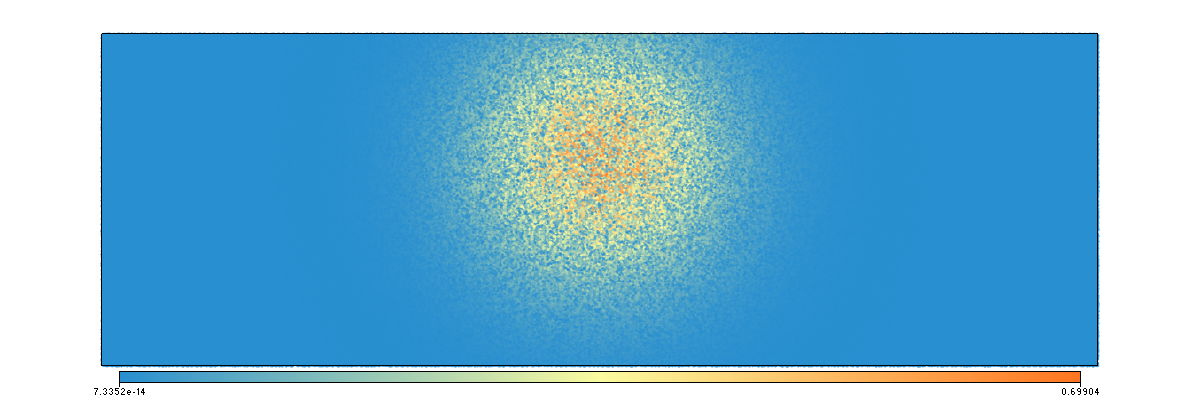

In [20]:
Fig = glucifer.Figure(figsize=(1200, 400))
Fig.Points(Model.swarm, Model.plasticStrain, fn_size=4.0)
Fig.show()

**Passive Tracers**

In [21]:
x = (Model.maxCoord[0] - Model.minCoord[0]) / 2.0 # This is the center of the model
#y = 0.0 * u.kilometer # The point is located at the surface, initially set at 0.

# top of crust
central_tracer = Model.add_passive_tracers(name="central", vertices=[x,crustUpper.top])

In [22]:
import numpy as np

npoints = 1000 # This is the number of points used to define the surface
x = np.linspace(Model.minCoord[0], Model.maxCoord[0], npoints) * u.kilometer
y = crustUpper.top
crustUpper_tracers = Model.add_passive_tracers(name="CrustUpper", vertices=[x,y])

crustLower_tracers = Model.add_passive_tracers(name="CrustLower", vertices=[x,crustLower.top])
moho_tracers = Model.add_passive_tracers(name="Moho", vertices=[x,y-35.*u.kilometer])

In [23]:
#y = sediment.top
sediment_tracers = Model.add_passive_tracers(name="Sediment", vertices=[x,sediment.top])

**Grid Tracers**

In [24]:
x_cu, y_cu = GEO.circles_grid(radius=2.0*u.kilometer, 
                    minCoord=[Model.minCoord[0], crustUpper.bottom], 
                    maxCoord=[Model.maxCoord[0], crustUpper.top])

x_cl, y_cl = GEO.circles_grid(radius=2.0*u.kilometer, 
                    minCoord=[Model.minCoord[0], crustLower.bottom], 
                    maxCoord=[Model.maxCoord[0], crustLower.top])

FSE_CrustUpper = Model.add_passive_tracers(name="FSE_CrustUpper", vertices=[x_cu, y_cu])
FSE_CrustLower = Model.add_passive_tracers(name="FSE_CrustLower", vertices=[x_cl, y_cl])

x_m, y_m = GEO.circles_grid(radius=2.0*u.kilometer, 
                    minCoord=[Model.minCoord[0], mantleLithosphere.bottom], 
                    maxCoord=[Model.maxCoord[0], mantleLithosphere.top])

FSE_Mantle = Model.add_passive_tracers(name="FSE_Mantle", vertices=[x_m, y_m])


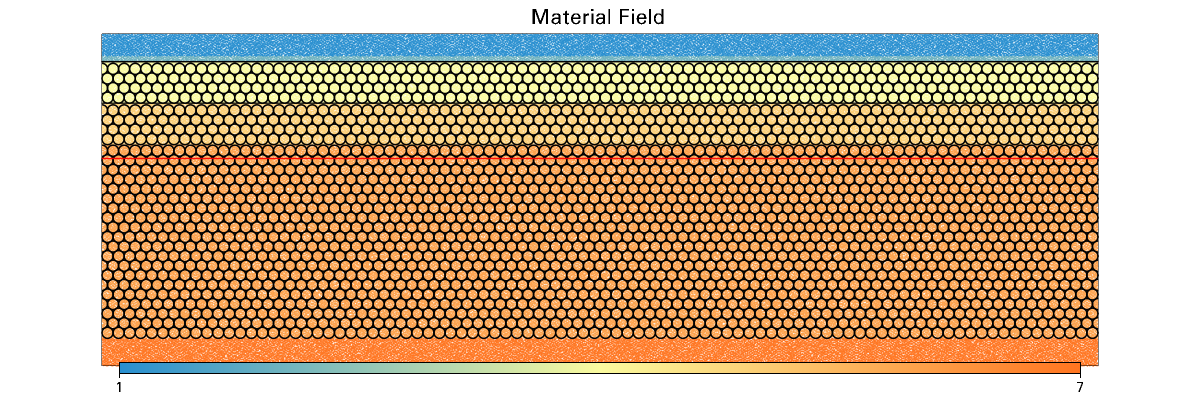

In [25]:
Fig = glucifer.Figure(figsize=(1200,400), title="Material Field", quality=2)
Fig.Points(crustUpper_tracers.swarm, pointSize=2.0)
Fig.Points(sediment_tracers.swarm, pointSize=2.0)
Fig.Points(crustLower_tracers.swarm, pointSize=2.0)
Fig.Points(crustUpper_tracers.swarm, pointSize=2.0)
Fig.Points(moho_tracers.swarm, pointSize=2.0, colour="red")
Fig.Points(FSE_CrustUpper.swarm, pointSize=2.0)
Fig.Points(FSE_CrustLower.swarm, pointSize=2.0)
Fig.Points(FSE_Mantle.swarm, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

# Compute initial condition

In [26]:
Model.init_model()


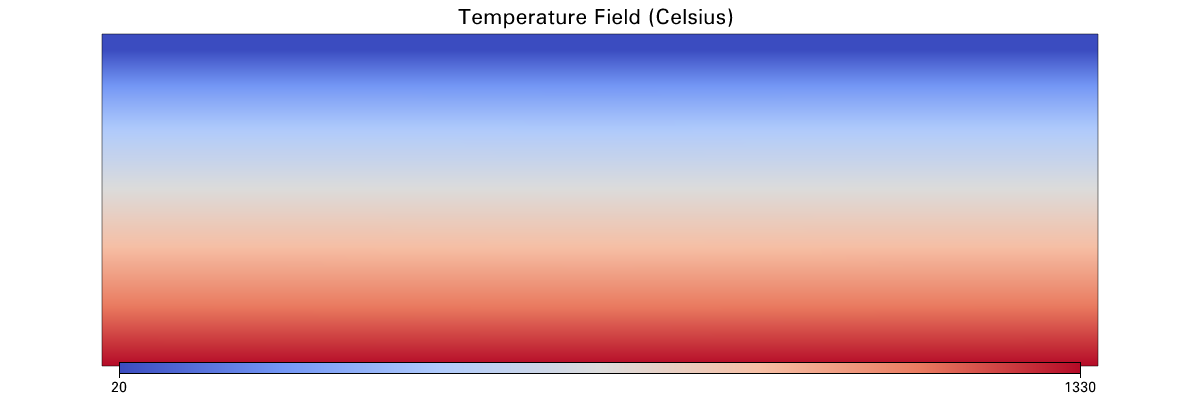

In [27]:
Fig = glucifer.Figure(figsize=(1200,400), title="Temperature Field (Celsius)", quality=3)
Fig.Surface(Model.mesh, GEO.Dimensionalize(Model.temperature, u.degC), colours="coolwarm")
Fig.show()


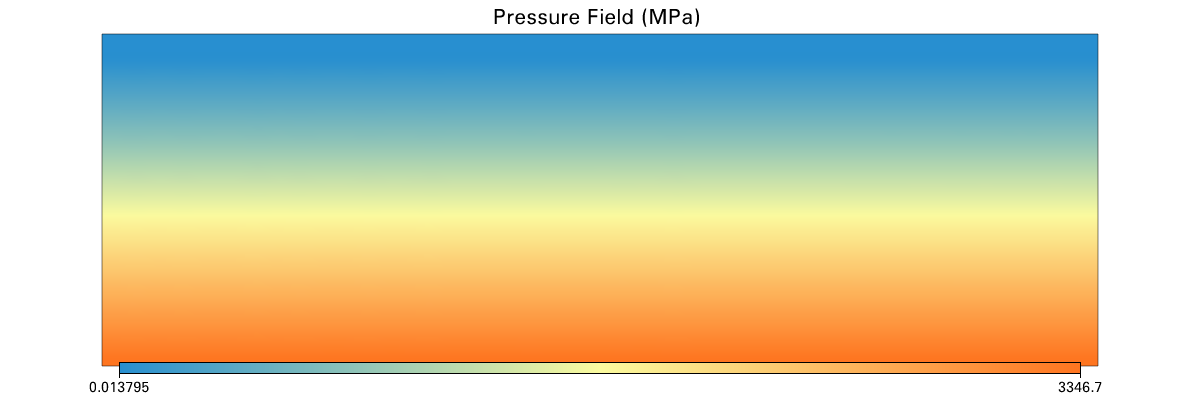

In [28]:
Fig = glucifer.Figure(figsize=(1200,400), title="Pressure Field (MPa)", quality=3)
Fig.Surface(Model.mesh, GEO.Dimensionalize(Model.pressureField, u.megapascal))
Fig.show()

## Basic Analysis of the initial set-up

Let's analyze the pressure and temperature field by creating a vertical profile at the center of the model.

In [29]:
# Only run this when in serial. Will fail in parallel

if GEO.uw.nProcs() == 1:

    import matplotlib.pyplot as plt

    moho_average_temperature = Model.temperature.evaluate(moho_tracers.swarm).mean()
    moho_average_temperature = GEO.Dimensionalize(moho_average_temperature, u.degC)

    print("Average Temperature at Moho: {0:5.0f}".format(moho_average_temperature))

    distances, temperature = GEO.extract_profile(Model.temperature, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])
    distances, pressure = GEO.extract_profile(Model.pressureField, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])

    Fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))
    ax1.plot(GEO.Dimensionalize(temperature, u.degK), GEO.Dimensionalize(distances, u.kilometer))
    ax1.set_xlabel("Temperature in Kelvin")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(100, 0)
    ax1.set_title("Temperature profile")

    ax2.plot(GEO.Dimensionalize(pressure, u.megapascal), GEO.Dimensionalize(distances, u.kilometer))
    ax2.set_xlabel("Pressure in megapascal")
    ax2.set_ylabel("Depth in kms")
    ax2.set_title("Pressure profile")
    ax2.set_ylim(100, 0)
    plt.show()

Average Temperature at Moho: 566 degC


<Figure size 1500x700 with 2 Axes>

In a similar fashion, one can extract a vertical profile of the viscosity field.


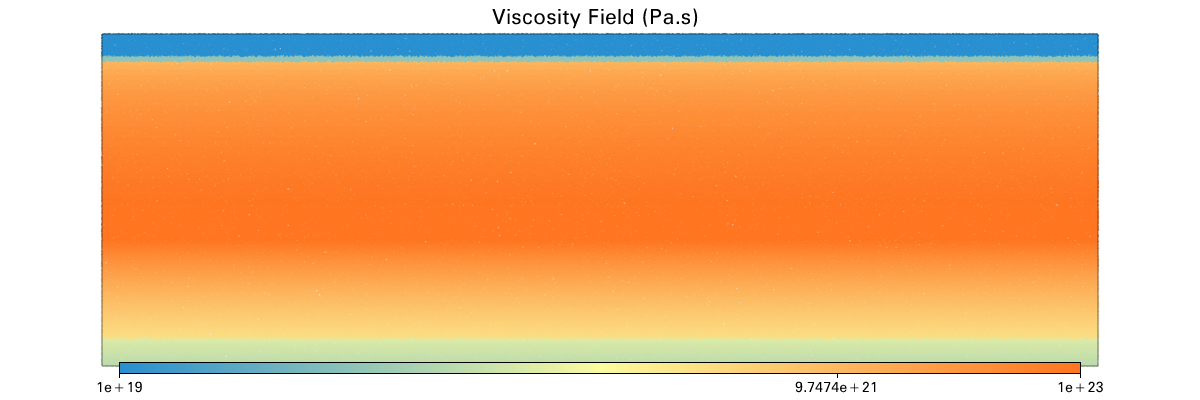

In [30]:
Fig = glucifer.Figure(figsize=(1200,400), title="Viscosity Field (Pa.s)", quality=3)
Fig.Points(Model.swarm, 
           GEO.Dimensionalize(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.show()

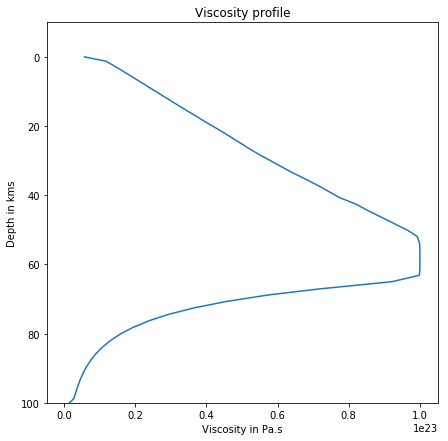

In [31]:
# Only run this when in serial. Will fail in parallel

if GEO.uw.nProcs() == 1:

    distances, viscosities = GEO.extract_profile(Model.projViscosityField, 
                                                 line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])
    distances, stresses = GEO.extract_profile(Model.projStressField, 
                                             line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])


    Fig, (ax1) = plt.subplots(1,1,figsize=(7,7))
    ax1.plot(GEO.Dimensionalize(viscosities, u.pascal * u.second), GEO.Dimensionalize(distances, u.kilometer))
    ax1.set_xlabel("Viscosity in Pa.s")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(100,-10)
    ax1.set_title("Viscosity profile")

## Solver options

In [32]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-4

# Run the Model

In [ ]:
#Model.run_for(nstep=2, checkpoint_interval=1)
Model.run_for(rift_time.to(u.megayear), checkpoint_interval=1)

Running with UWGeodynamics version 2.7.6
Options:  -remove_constant_pressure_null_space False -ksp_k2_type NULL -change_backsolve False -pc_type none -force_correction True -Q22_pc_type gkgdiag -change_A11rhspresolve False -ksp_type bsscr -rescale_equations False -restore_K False -A11_pc_type lu -A11_pc_factor_mat_solver_package mumps -A11_ksp_type preonly -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 0.03 megayear dt: 0.03 megayear (2019-04-05 05:16:12)
Step:     2 Model Time: 0.06 megayear dt: 0.03 megayear (2019-04-05 05:17:03)
Step:     3 Model Time: 0.10 megayear dt: 0.03 megayear (2019-04-05 05:17:52)
Step:     4 Model Time: 0.13 megayear dt: 0.03 megayear (2019-04-05 05:18:40)
Step:     5 Model Time: 0.16 megayear dt: 0.03 megayear (2019-04-05 05:19:28)
Step:     6 Model Time: 0.19 megayear dt: 0.03 megayear (2019-04-05 05:20:16)
Step:     7 Model Time: 0.23 megayear dt: 0.03 megayear (2019-04-05 05:21:03)
Step:     8 Model Time: 0.26 mega

In [ ]:
Fig = glucifer.Figure(figsize=(1200,400), title="Viscosity Field (Pa.s)", quality=3)
Fig.Points(Model.swarm, 
           GEO.Dimensionalize(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()

In [ ]:
Fig = glucifer.Figure(figsize=(1200,400), title="Viscosity Field (Pa.s)", quality=3)
Fig.Surface(Model.mesh, 
           GEO.Dimensionalize(Model.strainRateField, 1.0 / u.second),
           logScale=True)
Fig.show()

In [ ]:
Fig = glucifer.Figure(figsize=(1200,400), title="Material Index", quality=3)
Fig.Points(Model.swarm,
           Model.materialField,
           fn_size=2.0)
Fig.show()